<a href="https://colab.research.google.com/github/JayNguyen-123/CNN_Classifier_pytorch/blob/main/CNNClassifierPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


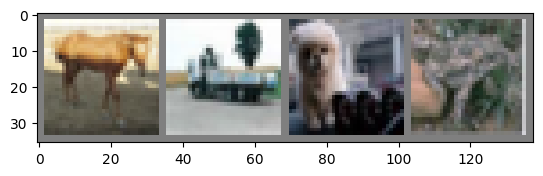

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some random training images
detailer = iter(trainloader)
images, labels = next(detailer)

# show images
imshow(torchvision.utils.make_grid(images))


In [ ]:
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


horse truck dog   frog 


### Define a Convolutional Neural Network


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)  # flatten all dimension except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = Net()



### Define a Loss function and Optimizer

In [ ]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



### Train the Network


In [ ]:
for epoch in range(2):    # loop over the dataset multiple time
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [input, labels]
    inputs, labels = data

    # zero the parameter gradient
    optimizer.zero_grad()

    # forward + backward + optimizer
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] Loss: {running_loss / 2000:.3f}')
      running_loss = 0.0
print("Finish Training")




[1,  2000] Loss: 1.866
[1,  4000] Loss: 1.666
[1,  6000] Loss: 1.597
[1,  8000] Loss: 1.514
[1, 10000] Loss: 1.485
[1, 12000] Loss: 1.416
[2,  2000] Loss: 1.347
[2,  4000] Loss: 1.310
[2,  6000] Loss: 1.323
[2,  8000] Loss: 1.282
[2, 10000] Loss: 1.271
[2, 12000] Loss: 1.259
Finish Training


In [ ]:
PATH = '/content/sample_data/cifar_model.pth'
torch.save(model.state_dict(), PATH)


### Test the model on the test data


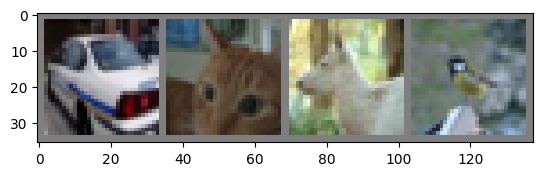

Ground Truth:  car  cat  deer bird 


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground Truth: ", ''.join((f'{classes[labels[j]]:5s}' for j in range(4))))


In [ ]:
model.load_state_dict(torch.load(PATH, weights_only=True))


<All keys matched successfully>

In [ ]:
_, predicted = torch.max(outputs, 1)
print("Predicted: ", ''.join(f'{classes[predicted[j]]:5s}' for j in range(4)))


Predicted:  car  cat  cat  bird 


In [ ]:
# check accuracy on test images
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data

    # calculate outputs by running images through the model
    outputs = model(images)

    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the 10000 test images: {100 * correct // total}%")


Accuracy of the model on the 10000 test images: 57%


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 63.8 %
Accuracy for class: car   is 73.5 %
Accuracy for class: bird  is 46.0 %
Accuracy for class: cat   is 49.8 %
Accuracy for class: deer  is 41.5 %
Accuracy for class: dog   is 37.9 %
Accuracy for class: frog  is 71.7 %
Accuracy for class: horse is 69.3 %
Accuracy for class: ship  is 61.9 %
Accuracy for class: truck is 62.4 %
